# UC Berkeley Milling Dataset
> Reproduces the results from the UC Berkeley Milling Dataset.

Here, we will reproduce the results, figures, and tables from the experiment using the UC Berekely Milling Dataset. You can find dataset on the [NASA Prognostics Repository](https://www.nasa.gov/content/prognostics-center-of-excellence-data-set-repository).

A detailed description of the dataset is found in the [PyPHM example notebook](https://github.com/tvhahn/PyPHM/blob/master/notebooks/milling_example.ipynb) (which you can also [run on Google Colab](https://colab.research.google.com/github/tvhahn/PyPHM/blob/master/notebooks/milling_example.ipynb)).

First step to reproduce the results is to get the proper environment setup and download the data.

## Table of Contents
* [1. Setup Notebook](#1.-Setup-Notebook) - clone the repo and import require packages
* [2. Explore Data](#2.-Explore-Data) - download the raw data and see how it looks
* [3. Create Train/Val/Test Sets](#3.-Create-Train/Val/Test-Sets) - create the data splits (if you want) and visualize them
* [4. Train Models with a Random Search](#4.-Train-Models-with-a-Random-Search) - train the models
* [5. Summarize Results](#5.-Summarize-Results) - summarize the results of the random search to find the most effective loss functions


# 1. Setup Notebook
**For Google Colab:**
To run the notebook on google colab you must clone the repo an download the data using PyPHM. This can be done by running the following cell.

In [ ]:
# ONLY RUN IF YOU'RE USING GOOGLE COLAB
!git clone https://github.com/tvhahn/tspipe

# move into project folder
%cd tspipe

!pip install tsfresh pyphm
!pip install -e .

from IPython.display import clear_output
clear_output()

**Import Packages:**
Don't skip this step! Needed for Google Colab and if run locally.

In [1]:
from pyphm.datasets.milling import MillingPrepMethodA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import scipy.io as sio # for reading matlab files
import zipfile
import gdown

import warnings
warnings.filterwarnings("ignore") # supress all the matplotlib deprecation warnings
from IPython.display import clear_output # incase you want to clear the output of a cell
%load_ext autoreload
%autoreload 2

In [2]:
# set the project (root folder) and the data folder locations
path_colab = Path.cwd().parent.parent / 'content'

if path_colab.exists():
    proj_dir = Path.cwd() # get projet folder of repository - use if on colab
else:
    proj_dir = Path.cwd().parent # on local machine in ./notebooks folder

print(proj_dir) 

/home/tim/Documents/feat-store


**Download the milling dataset:** We will use the [download_data.py](https://github.com/tvhahn/tspipe/blob/master/src/dataprep/download_data.py) script in the `src.dataprep` module to download the data.

In [3]:
!python {proj_dir}/src/dataprep/download_data.py -p {proj_dir}

2022-11-01 08:58:06,299 - __main__ - INFO - Download the datasets


# 2. Explore Data
We can now explore the milling dataset. For a full breakdown of the dataset, see the [example notebook in PyPHM](https://github.com/tvhahn/PyPHM/blob/master/notebooks/milling_example.ipynb) (Colab notebook [here](https://colab.research.google.com/github/tvhahn/PyPHM/blob/master/notebooks/milling_example.ipynb)).

We'll recreate the figure showing the six different signals using the `plot_raw_milling_signals` function from [visualize.py](https://github.com/tvhahn/tspipe/blob/master/src/visualization/visualize.py#L1075).

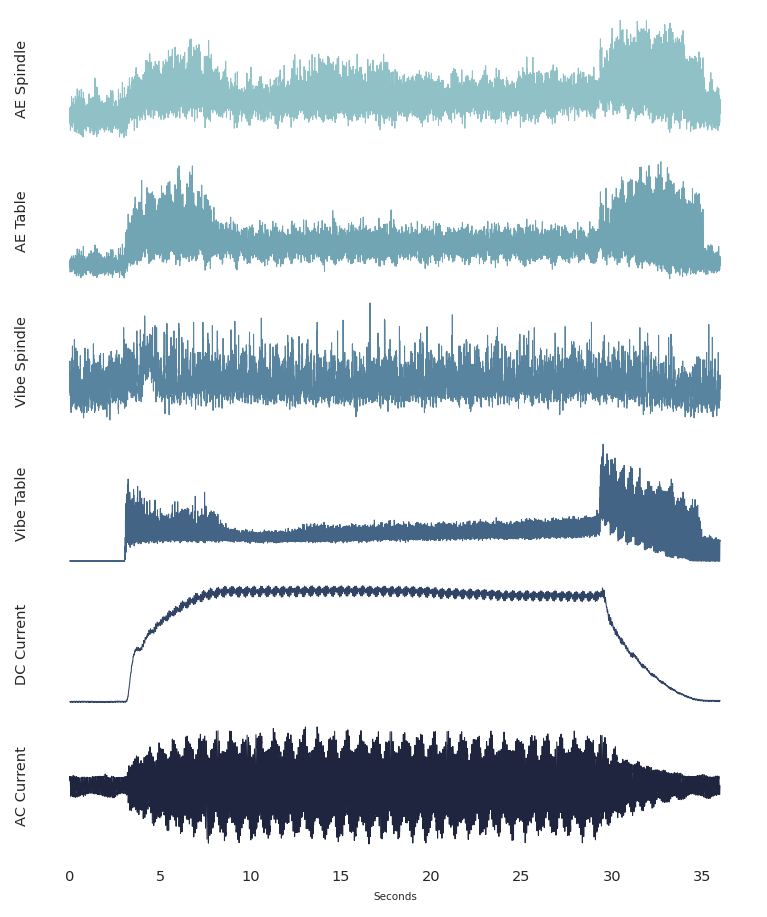

In [4]:
from src.visualization.visualize import plot_raw_milling_signals

raw_data_dir = proj_dir / 'data' / 'raw'

# use PyPHM to load the data
mill = MillingPrepMethodA(root=raw_data_dir, download=False)
data = mill.load_mat()

plot_raw_milling_signals(
    data,
    cut_no=145, # change the cut number to see different cuts
    save_plot=False,
)

# 3. Prep Data
Next, we will break each signal from the dataset into windows. In the paper, we used a window of 1024 and a stride of 64. However, if you are running this on Google Colab, we **need to use a smaller window length to avoid running out of memory**. We will use a window length of 64 and a stride of 64 for this case as a demonstration.

The below script, from [make_dataset_milling.py](https://github.com/tvhahn/tspipe/blob/master/src/dataprep/make_dataset_milling.py), creates the individual windows and saves them as a CSV file in the `data/raw/milling` directory.

In [5]:
# change the window length and stride
WINDOW_LEN = 64
STRIDE = 64
RAW_DIR_NAME = f'stride{STRIDE}_len{WINDOW_LEN}'

In [6]:
# run the script
!python {proj_dir}/src/dataprep/make_dataset_milling.py \
	-p {proj_dir} \
	--path_data_dir {proj_dir}/data/ \
	--window_len {WINDOW_LEN} \
	--stride {STRIDE} \
	--raw_dir_name {RAW_DIR_NAME}

2022-11-01 08:58:18,299 - __main__ - INFO - Creating windows of the milling dataset
path_data_dir: /home/tim/Documents/feat-store/data
Shape of final df: (740480, 11)
Saving dataframe as milling.csv.gz ...


In [7]:
# load the milling.csv.gz file with pandas
df = pd.read_csv(proj_dir / 'data' / 'raw' / 'milling' / RAW_DIR_NAME / 'milling.csv.gz')
df.head()

,cut_id,cut_no,case,time,ae_spindle,ae_table,vib_spindle,vib_table,smcdc,smcac,tool_class
0,0_0,0,1,0.000,0.219727,0.272827,0.733643,2.116699,6.840820,0.124512,0
1,0_0,0,1,0.004,0.246582,0.322266,0.778809,2.277832,6.660156,-0.561523,0
2,0_0,0,1,0.008,0.294189,0.283813,0.758057,2.343750,6.508789,-2.099609,0
3,0_0,0,1,0.012,0.323486,0.260010,0.726318,2.448730,6.542969,-2.731934,0
4,0_0,0,1,0.016,0.290527,0.253296,0.653076,2.546387,6.621094,-3.505859,0


The dataframe, above, can now be used with the [tsfresh](https://github.com/blue-yonder/tsfresh) feature engineering package. We'll use that next.

# 4. Feature Engineering
The features are created using tsfresh. The features are created from a pandas dataframe using a dictionary of feature extraction functions.

In the original paper, we used the `comprehensive_features` dictionary from the [feat_param_dict.py](https://github.com/tvhahn/tspipe/blob/master/src/features/feat_param_dict.py). However, using the comprehensive features takes a long time to compute and will likely crash the Google Colab. For this notebook, we will use a smaller set of features, called `dummy`, which is also defined in the [feat_param_dict.py](https://github.com/tvhahn/tspipe/blob/master/src/features/feat_param_dict.py) file.

We will use the [build_features.py](https://github.com/tvhahn/tspipe/blob/master/src/features/build_features.py) script to create the features. Below are the variables used when calling the script:

In [9]:
# change these variables for the script
DATASET = 'milling' # either 'milling' or 'cnc'
PROCESSED_DIR_NAME = 'milling_features' # name of folder to save features in
FEAT_FILE_NAME = 'milling_features.csv' # name of file to save features in
RAW_DIR_NAME = f'stride{STRIDE}_len{WINDOW_LEN}' # name of folder containing raw data
RAW_FILE_NAME = 'milling.csv.gz' # name of file containing raw data
FEAT_DICT_NAME = 'dummy' # as defined in build_features.py. Either 'dummy' or 'comp'
N_CORES = 4 # number of cores to use for multiprocessing

In [9]:
# run the script
!python {proj_dir}/src/features/build_features.py \
	-p {proj_dir} \
	--dataset {DATASET} \
	--path_data_dir {proj_dir}/data/ \
	--raw_dir_name {RAW_DIR_NAME} \
	--raw_file_name {RAW_FILE_NAME} \
	--processed_dir_name {PROCESSED_DIR_NAME} \
	--feat_file_name {FEAT_FILE_NAME} \
	--feat_dict_name {FEAT_DICT_NAME} \
	--n_cores {N_CORES}

2022-10-26 09:50:07,672 - __main__ - INFO - making final features set from raw data
df.columns Index(['cut_id', 'cut_no', 'case', 'time', 'ae_spindle', 'ae_table',
       'vib_spindle', 'vib_table', 'smcdc', 'smcac', 'tool_class'],
      dtype='object')
Shape of df: (740480, 11)
2022-10-26 09:50:08,539 - __main__ - INFO - extracting features from raw milling dataframe
Feature Extraction: 100%|███████████████████████| 20/20 [00:08<00:00,  2.34it/s]


Again, we can look at the features we just created.

In [10]:
# load the milling.csv.gz file with pandas
df_feat = pd.read_csv(proj_dir / 'data' / 'processed' / 'milling' / PROCESSED_DIR_NAME / FEAT_FILE_NAME)
df_feat.head()

,cut_id,ae_spindle__length,ae_spindle__kurtosis,ae_table__length,ae_table__kurtosis,vib_spindle__length,vib_spindle__kurtosis,vib_table__length,vib_table__kurtosis,smcdc__length,smcdc__kurtosis,smcac__length,smcac__kurtosis,cut_no,case,tool_class
0,0_0,64.0,-0.348446,64.0,-0.190215,64.0,-0.126833,64.0,2.144662,64.0,-0.256599,64.0,-1.367461,0,1,0
1,0_1,64.0,0.724161,64.0,-0.236114,64.0,0.504015,64.0,2.357173,64.0,0.384966,64.0,-1.248971,0,1,0
2,0_10,64.0,0.412827,64.0,0.031749,64.0,0.536186,64.0,2.901181,64.0,-0.167447,64.0,-1.327537,0,1,0
3,0_11,64.0,-0.087264,64.0,-0.376136,64.0,0.511172,64.0,2.578223,64.0,-0.367538,64.0,-1.441127,0,1,0
4,0_12,64.0,1.012060,64.0,1.804934,64.0,-0.108143,64.0,2.400641,64.0,-0.038878,64.0,-1.279095,0,1,0


The actual feature dataset used in the paper is much larger. We can download it from Google Drive and take a look at it.

In [11]:
path_processed_dir = proj_dir / 'data' / 'processed' / 'milling' / 'milling_features_comp_stride64_len1024'
path_processed_dir.mkdir(parents=True, exist_ok=True)

FEAT_FILE_NAME = 'milling_features_comp_stride64_len1024.zip' # name of the original feature file

In [13]:
# download the file from google drive if it hasn't been yet
gdown.download(
    id='1I0OjXVSkBBxhw3w8KtWbITRR0yAeKk8j', 
    output=str(path_processed_dir / FEAT_FILE_NAME), 
    quiet=False
    )

# extract the zip file
print("Extracting...")
with zipfile.ZipFile(path_processed_dir / FEAT_FILE_NAME, 'r') as zip_ref:
    zip_ref.extractall(path_processed_dir)

Downloading...
From: https://drive.google.com/uc?id=1I0OjXVSkBBxhw3w8KtWbITRR0yAeKk8j
To: /home/tim/Documents/feat-store/data/processed/milling/milling_features_comp_stride64_len1024/milling_features_comp_stride64_len1024.zip
100%|██████████| 321M/321M [00:04<00:00, 65.6MB/s] 


In [12]:
# load the milling_features_comp_stride64_len1024.csv in pandas
df_feat = pd.read_csv(path_processed_dir / 'milling_features_comp_stride64_len1024.csv')
df_feat.head()

,cut_id,smcac__time_reversal_asymmetry_statistic__lag_1,smcac__time_reversal_asymmetry_statistic__lag_2,smcac__time_reversal_asymmetry_statistic__lag_3,smcac__c3__lag_1,smcac__c3__lag_2,smcac__c3__lag_3,smcac__cid_ce__normalize_True,smcac__cid_ce__normalize_False,smcac__symmetry_looking__r_0.0,...,smcdc__query_similarity_count__query_None__threshold_0.0,"smcdc__matrix_profile__feature_""min""__threshold_0.98","smcdc__matrix_profile__feature_""max""__threshold_0.98","smcdc__matrix_profile__feature_""mean""__threshold_0.98","smcdc__matrix_profile__feature_""median""__threshold_0.98","smcdc__matrix_profile__feature_""25""__threshold_0.98","smcdc__matrix_profile__feature_""75""__threshold_0.98",cut_no,case,tool_class
0,87_20,-0.009862,-0.008820,0.002745,-0.997182,-0.733741,-0.354140,11.424614,17.725740,0.0,...,NaN,3.789384,5.941307,4.691854,4.617381,3.912163,5.372661,87,11,1
1,87_21,-0.014233,-0.006940,0.003651,-1.006841,-0.739986,-0.355168,11.403917,17.642734,0.0,...,NaN,3.022031,5.579988,3.749164,3.582706,3.339192,4.022824,87,11,1
2,87_22,-0.023152,-0.024342,-0.000312,-1.067194,-0.764072,-0.354402,11.388923,17.604872,0.0,...,NaN,2.896524,5.421811,3.517452,3.349038,3.180649,3.620394,87,11,1
3,87_23,-0.008329,-0.001119,0.017044,-1.070455,-0.782522,-0.374350,11.327472,17.496560,0.0,...,NaN,2.866619,5.212993,3.357202,3.245255,3.119372,3.488481,87,11,1
4,87_24,0.006926,0.018749,0.019649,-1.014428,-0.744961,-0.359926,11.280507,17.361086,0.0,...,NaN,2.866619,4.435201,3.249217,3.202348,3.032700,3.403513,87,11,1


Let's get some statistics on the feature dataset.

In [13]:
# get the percentage of each tool_class
df_p = df_feat.groupby("tool_class").size() / df_feat.shape[0] * 100
df_p = df_p.reset_index()
df_p.columns = ["tool_class", "percentage"]

# get the count of each tool_class
df_c = df_feat.groupby("tool_class").size().to_frame().reset_index()
df_c.columns = ["tool_class", "count"]

# merge the two dataframes
df_pc = df_p.merge(df_c, on="tool_class")[["tool_class", "count", "percentage"]]
df_pc["percentage"] = df_pc["percentage"].round(2)
df_pc

,tool_class,count,percentage
0,0,3311,36.63
1,1,5065,56.03
2,2,664,7.35


# 4. Model Training
A random search is used to find the best model and hyperparameters. The random search is implemented in the [train.py](https://github.com/tvhahn/tspipe/blob/master/src/models/train.py) script. The parameters to search over are initialized in the [random_search_setup.py](https://github.com/tvhahn/tspipe/blob/master/src/models/random_search_setup.py) -- when you clone the repo to your local computer you can modify it there.

In [14]:
DATASET = 'milling' # either 'milling' or 'cnc'
SAVE_DIR_NAME = 'interim_results_milling' # name of folder to results in
PROCESSED_DIR_NAME = 'milling_features_comp_stride64_len1024' # name of folder where features are saved
RAND_SEARCH_ITER = 10 # number of iterations for random search
FEAT_FILE_NAME = 'milling_features_comp_stride64_len1024.csv' # name of the original feature file

In [15]:
!python {proj_dir}/src/models/train.py \
    -p {proj_dir} \
    --dataset {DATASET} \
    --save_dir_name {SAVE_DIR_NAME} \
    --processed_dir_name {PROCESSED_DIR_NAME} \
    --rand_search_iter {RAND_SEARCH_ITER} \
    --feat_file_name {FEAT_FILE_NAME}

Assume on local compute
k_folds: 7
classifier: nb, oversamp_method: None, oversamp_ratio: None undersamp_method: random_under undersamp_ratio: 0.5

 {}
feat_select_method:  random
k_folds in kfold_cv:  7
0
no scaling
performing random feature selection
x_train shape: (1992, 10)
1
no scaling
using already selected features
x_train shape: (1992, 10)
/home/tim/Documents/feat-store/src/models/utils.py:229: RuntimeWarning: invalid value encountered in divide
  f1_scores = (2 * precisions * recalls) / (precisions + recalls)
2
no scaling
using already selected features
x_train shape: (1992, 10)
3
no scaling
using already selected features
x_train shape: (1992, 10)
4
no scaling
using already selected features
x_train shape: (1992, 10)
5
no scaling
using already selected features
x_train shape: (1992, 10)
6
no scaling
using already selected features
x_train shape: (1992, 10)
/home/tim/Documents/feat-store/src/models/utils.py:229: RuntimeWarning: invalid value encountered in divide
  f1_scores =